In [ ]:
%%capture
!pip install -q llama-index llama-index-llms-huggingface llama-index-embeddings-huggingface
!pip install -q transformers accelerate bitsandbytes sentence-transformers pypdf huggingface_hub
!pip install -q evaluate rouge_score sacrebleu bert_score

In [ ]:
%%capture
!pip install -U transformers accelerate bitsandbytes llama-index-llms-huggingface

In [ ]:
from huggingface_hub import login
login()

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
json_file_path = "/content/drive/MyDrive/emre/hukuk_dataset.json"

if not os.path.exists(json_file_path):
    print(f"\nHATA: Belirtilen yolda dosya bulunamadı: {json_file_path}")
    sys.exit("Dosya bulunamadı.")

print(f"Dosya bulundu: {json_file_path}")

Dosya bulundu: /content/drive/MyDrive/emre/hukuk_dataset.json


In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-m3", embed_batch_size=16)

Settings.embed_model = embed_model
Settings.chunk_size = 1024
Settings.chunk_overlap = 100

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader

try:
    documents = SimpleDirectoryReader(input_files=[json_file_path]).load_data()

    vector_index = VectorStoreIndex.from_documents(documents)

except Exception as e:
    print(f"Veri yükleme sırasında hata oluştu: {e}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
import gc
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core import PromptTemplate
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import evaluate

rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')
bertscore = evaluate.load('bertscore')

QUERY = "Kasten öldürmenin cezası nedir? Hangi hallerde ağırlaştırılmış müebbet verilir?"

models = [
    {"name": "Llama-3.1-8B-Instruct", "id": "meta-llama/Llama-3.1-8B-Instruct"},

    {"name": "Gemma-2-9B-IT", "id": "google/gemma-2-9b-it"},

    {"name": "Mistral-7B-v0.3", "id": "mistralai/Mistral-7B-Instruct-v0.3"}
]

standard_template_str = (
    "Sen uzman bir Türk Hukuku asistanısın.\n"
    "Aşağıdaki kanun maddelerini ve bağlamı dikkatlice incele.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Sadece yukarıdaki bağlamı kullanarak, soruyu detaylı, maddeler halinde ve profesyonel bir dille cevapla.\n"
    "Asla bağlam dışı bilgi uydurma.\n"
    "Soru: {query_str}\n"
    "Cevap: "
)

gemma_template_str = (
    "<start_of_turn>user\n"
    "Sen uzman bir Türk Hukuku asistanısın. Aşağıdaki bağlamı kullanarak soruyu cevapla.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Soru: {query_str}<end_of_turn>\n"
    "<start_of_turn>model\n"
)


results = []

def get_similarity_score(text1, text2, embed_model):
    if not text1 or not text2: return 0.0
    vec1 = np.array(embed_model.get_text_embedding(text1)).reshape(1, -1)
    vec2 = np.array(embed_model.get_text_embedding(text2)).reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0][0]

for model_info in models:
    model_name = model_info["name"]
    model_id = model_info["id"]

    print(f"\nModel : {model_name}")

    try:

        model_kwargs = {
            "torch_dtype": torch.bfloat16,
        }

        if "gemma" in model_name.lower():
            model_kwargs["attn_implementation"] = "eager"

        llm = HuggingFaceLLM(
            model_name=model_id,
            tokenizer_name=model_id,
            context_window=8192,
            max_new_tokens=1024,
            model_kwargs=model_kwargs,
            generate_kwargs={"temperature": 0.1, "do_sample": False},
            device_map="auto",
        )

        if "gemma" in model_name.lower():
            active_template = PromptTemplate(gemma_template_str)
            print(f"-> {model_name} için özel Gemma şablonu kullanılıyor.")
        else:
            active_template = PromptTemplate(standard_template_str)
            print(f"-> {model_name} için standart şablon kullanılıyor.")

        query_engine = vector_index.as_query_engine(
            llm=llm,
            similarity_top_k=5,
            text_qa_template=active_template
        )

        response = query_engine.query(QUERY)
        generated_text = str(response).strip()

        if response.source_nodes:
            source_text = response.source_nodes[0].node.get_text()
        else:
            source_text = "Alakalı kaynak bulunamadı"

        # Cosine Similarity
        cos_score = get_similarity_score(generated_text, source_text, embed_model)

        # ROUGE (Özetleme Başarısı)
        # ROUGE-L: En uzun ortak alt diziye bakar.
        if source_text:
            rouge_results = rouge.compute(predictions=[generated_text], references=[source_text])
            rouge_l_score = rouge_results['rougeL']
        else:
            rouge_l_score = 0.0

        # BLEU (Hassasiyet)
        if source_text:
            bleu_results = bleu.compute(predictions=[generated_text], references=[source_text])
            bleu_score = bleu_results['bleu']
        else:
            bleu_score = 0.0

        # BERTScore (Anlamsal Derinlik)
        if source_text:
            bert_results = bertscore.compute(predictions=[generated_text], references=[source_text], lang="tr")
            bert_f1_score = np.mean(bert_results['f1'])
        else:
            bert_f1_score = 0.0

        print(f"{model_name} Cevabı :\n{generated_text}")
        print(f"Cosine: {cos_score:.3f} | ROUGE-L: {rouge_l_score:.3f} | BLEU: {bleu_score:.3f} | BERTScore: {bert_f1_score:.3f}")

        results.append({
            "Model": model_name,
            "Cevap": generated_text,
            "Cosine Sim": cos_score,
            "ROUGE-L": rouge_l_score,
            "BLEU": bleu_score,
            "BERTScore": bert_f1_score
        })

    except Exception as e:
        print(f"HATA ({model_name}): {e}")

    del llm
    del query_engine
    del response
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Bellek temizlendi.\n" + "-"*30)

`torch_dtype` is deprecated! Use `dtype` instead!



Model : Llama-3.1-8B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


-> Llama-3.1-8B-Instruct için standart şablon kullanılıyor.


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Llama-3.1-8B-Instruct Cevabı :
1. Kasten öldürme suçunun cezası, Türk Ceza Kanunu'nun 81. maddesinde belirlenmiştir. Bu maddeye göre, kasten öldürme suçunun cezası müebbet hapis cezasıdır. 2. Ağırlaştırılmış müebbet hapis cezası, kasten öldürme suçunun belirli hallerinde verilir. Bu haller, Türk Ceza Kanunu'nun 82. maddesinde belirlenmiştir. Ağırlaştırılmış müebbet hapis cezası, aşağıdaki hallerde verilir: a) Tasarlayarak, b) Canavarca hisle veya eziyet çektirerek, c) Yangın, su baskını, tahrip, batırma veya bombalama ya da nükleer, biyolojik veya kimyasal silah kullanmak suretiyle, d) Üstsoy veya altsoydan birine ya da eş, boşandığı eş veya kardeşe karşı, e) Çocuğa ya da beden veya ruh bakımından kendisini savunamayacak durumda bulunan kişiye karşı, f) (Değişik: 12/5/2022-7406/2 md.) Kadına karşı, g) Kişinin yerine getirdiği kamu görevi nedeniyle, h) Bir suçu gizlemek, delillerini ortadan kaldırmak veya işlenmesini kolaylaştırmak ya da yakalanmamak amacıyla, i) (Ek: 29/6/2005 - 5377/9

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


-> Gemma-2-9B-IT için özel Gemma şablonu kullanılıyor.
Gemma-2-9B-IT Cevabı :
Kasten öldürme suçunun cezası **müebbet hapis** cezasıdır. 

Aşağıdaki hallerde kasten öldürme suçunun cezası **ağırlaştırılmış müebbet hapis** cezasına yükselir:

* Tasarlayarak
* Canavarca hisle veya eziyet çektirerek
* Yangın, su baskını, tahrip, batırma veya bombalama ya da nükleer, biyolojik veya kimyasal silah kullanmak suretiyle
* Üstsoy veya altsoydan birine ya da eş, boşandığı eş veya kardeşe karşı
* Çocuğa ya da beden veya ruh bakımından kendisini savunamayacak durumda bulunan kişiye karşı
* Kadına karşı
* Kişinin yerine getirdiği kamu görevi nedeniyle
* Bir suçu gizlemek, delillerini ortadan kaldırmak veya işlenmesini kolaylaştırmak veya yakalanmamak amacıyla
* Kan gütme saikiyle
* Töre saikiyle
Cosine: 0.834 | ROUGE-L: 0.416 | BLEU: 0.013 | BERTScore: 0.587
Bellek temizlendi.
------------------------------

Model : Mistral-7B-v0.3


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


-> Mistral-7B-v0.3 için standart şablon kullanılıyor.
Mistral-7B-v0.3 Cevabı :
İlk soruyu cevaplamak için, Türk Ceza Kanunu'nun 81. madde'sine bakılmalıdır. Bu madde, kasten öldürmenin cezasının müebbet hapis cezası olarak belirler. Ağırlaştırılmış müebbet hapis cezası, kasten öldürme suçunun nitelikli hallerinde verilir. Bu haller, 82. madde'de belirtilmektedir.
Cosine: 0.829 | ROUGE-L: 0.122 | BLEU: 0.000 | BERTScore: 0.425
Bellek temizlendi.
------------------------------


In [ ]:
df_results = pd.DataFrame(results)

print("\nKARŞILAŞTIRMA TABLOSU")
display(df_results)


KARŞILAŞTIRMA TABLOSU


,Model,Cevap,Cosine Sim,ROUGE-L,BLEU,BERTScore
0,Llama-3.1-8B-Instruct,"1. Kasten öldürme suçunun cezası, Türk Ceza Ka...",0.892061,0.425574,0.329152,0.673877
1,Gemma-2-9B-IT,Kasten öldürme suçunun cezası **müebbet hapis*...,0.833652,0.416342,0.013216,0.586666
2,Mistral-7B-v0.3,"İlk soruyu cevaplamak için, Türk Ceza Kanunu'n...",0.828805,0.122449,0.000000,0.424566


In [ ]:
!pip install -q matplotlib seaborn scikit-learn

/tmp/ipython-input-1452267946.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df_results, ax=ax, palette=colors)
/tmp/ipython-input-1452267946.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df_results, ax=ax, palette=colors)
/tmp/ipython-input-1452267946.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=df_results, ax=ax, palette=colors)
/tmp/ipython-input-1452267946.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

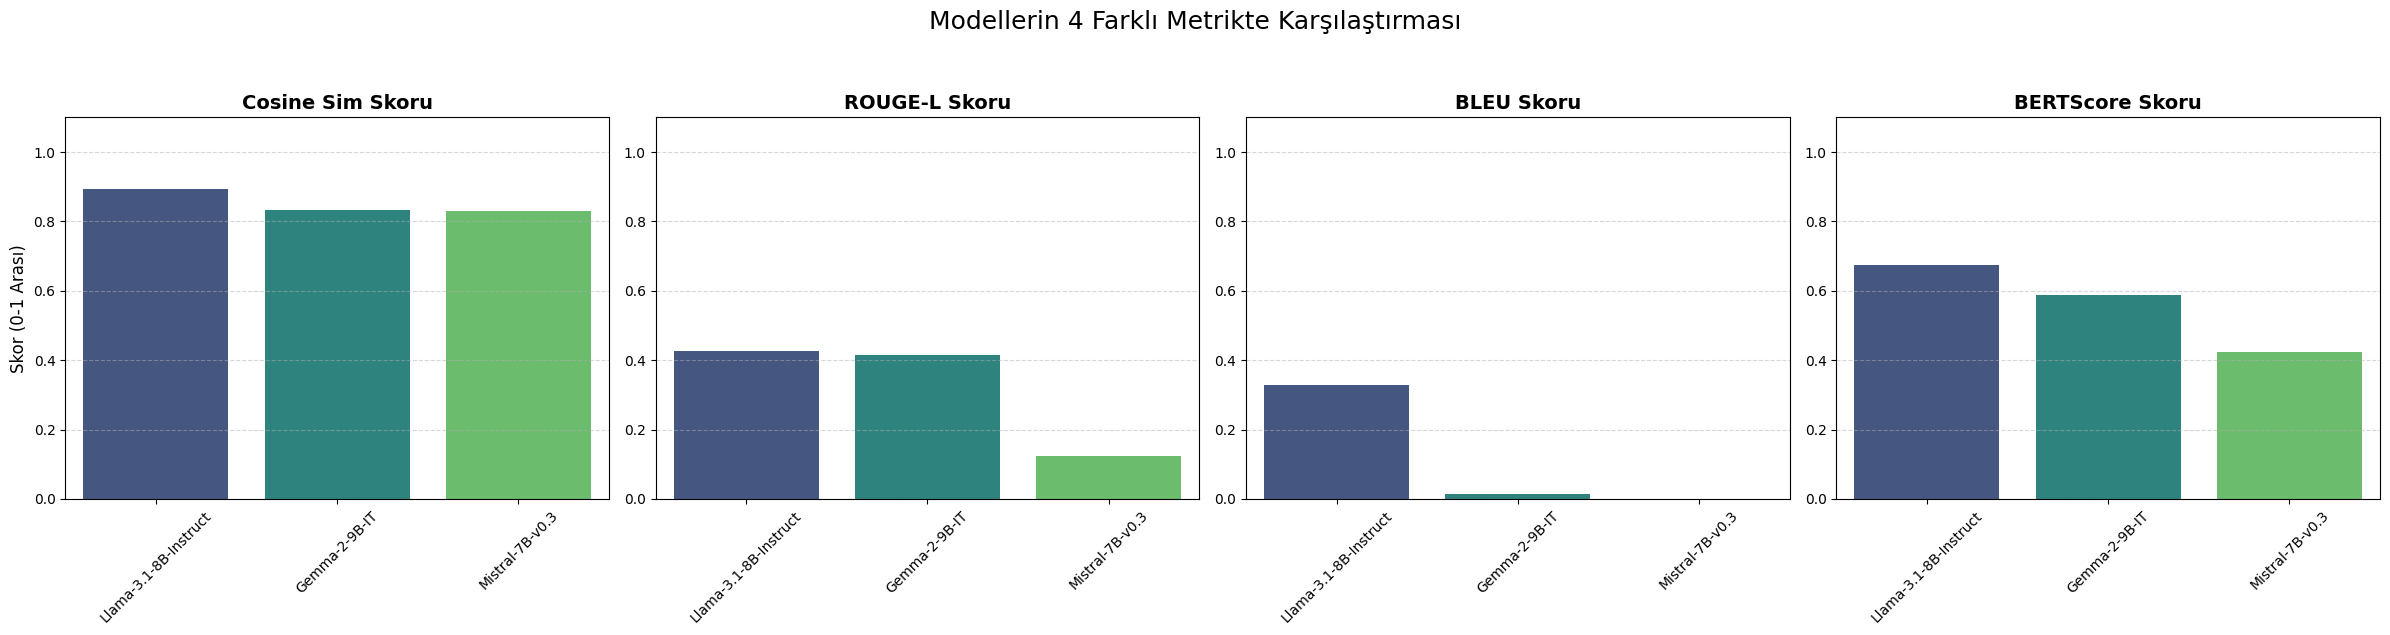

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik Boyutları ve Çerçeve (1 Satır, 4 Sütun)
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Çizilecek Metrikler
metrics_to_plot = ['Cosine Sim', 'ROUGE-L', 'BLEU', 'BERTScore']

# Renk Paleti
colors = sns.color_palette("viridis", n_colors=len(df_results))

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]

    # Bar Chart Çizimi
    sns.barplot(x="Model", y=metric, data=df_results, ax=ax, palette=colors)

    # Başlık ve Eksen Ayarları
    ax.set_title(f"{metric} Skoru", fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1.1)  # Y ekseni her zaman 0-1.1 arasında olsun
    ax.set_xlabel("")    # X ekseni yazısını kaldır (zaten model isimleri var)

    # Sadece ilk grafikte "Skor" yazısı olsun, diğerleri sade kalsın
    if i == 0:
        ax.set_ylabel("Skor (0-1 Arası)", fontsize=12)
    else:
        ax.set_ylabel("")

    # Izgara çizgileri ekle (Okunabilirliği artırır)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Model isimlerini 45 derece eğik yaz (Uzun isimler sığsın diye)
    ax.tick_params(axis='x', rotation=45)

# Genel Başlık
plt.suptitle("Modellerin 4 Farklı Metrikte Karşılaştırması", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

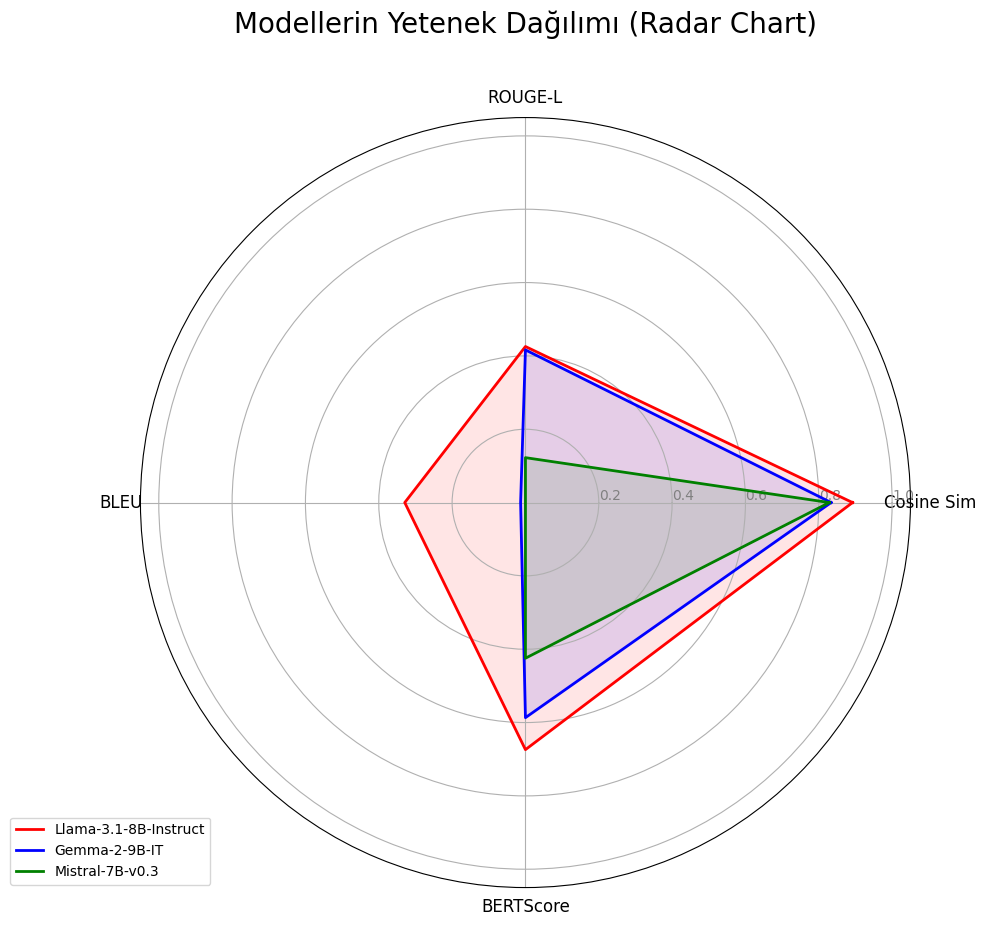

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# 1. Metrik Listesi
metrics = ['Cosine Sim', 'ROUGE-L', 'BLEU', 'BERTScore']
N = len(metrics)

# 2. Açıların Hesaplanması (Daireyi N parçaya böl)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Grafiği kapatmak için ilk açıyı sona ekle

# 3. Çizim Alanı Oluşturma
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True) # Polar=True dairesel grafik demektir

# 4. Eksen Etiketleri (Saat yönünde)
# Açılara karşılık gelen metrik isimlerini yaz
plt.xticks(angles[:-1], metrics, color='black', size=12)

# 5. Y Ekseni Etiketleri (İç halkalar)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
plt.ylim(0, 1.05) # Sınırı 1.05 yapıyoruz ki çizgiler taşmasın

# 6. Verileri Çizdirme
colors = ['red', 'blue', 'green', 'orange', 'purple'] # Modeller için renkler

for i, row in df_results.iterrows():
    values = row[metrics].tolist()
    values += values[:1]  # Değer döngüsünü kapat

    color = colors[i % len(colors)]

    # Çizgi çiz
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Model'], color=color)

    # İçini hafif boya
    ax.fill(angles, values, color=color, alpha=0.1)

# 7. Başlık ve Lejant
plt.title('Modellerin Yetenek Dağılımı (Radar Chart)', size=20, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()